In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize
import pandas as pd

Using TensorFlow backend.


In [2]:
model = "../../models/april-10/88-69-5/"
new_saver = tf.train.import_meta_graph(model + "model.meta")
new_saver.restore(sess, tf.train.latest_checkpoint(model))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../models/april-10/88-69-5/model


In [4]:
for i in range(50):
    try:
        fm = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
labels = tf.get_default_graph().get_tensor_by_name("Placeholder_2:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

In [105]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
max_all = [0.20792677521705638,
 0.2990041905641556,
 0.4360648360848427,
 0.5161105132102968,
 0.4825860628485681,
 0.4943232241272928,
 0.5178957056999209,
 0.5291672283411026,
 0.6659183305501939,
 0.6092100739479065,
 0.37346625328063965,
 0.7162704998254776,
 0.40363759160041823,
 0.6478493613004686,
 0.8438000082969666,
 0.15365000069141388]

min_all = [0.01872335869818926,
 0.03467957343906164,
 0.021185510214418172,
 0.08898216009140014,
 0.052402322441339494,
 0.07628638863563539,
 0.083824477866292,
 0.08768215030431747,
 0.05718051139265299,
 0.0372315139323473,
 0.0,
 0.007564654648303981,
 -0.019136652257293465,
 0.0064204379683360435,
 0.006225000135600567,
 4.999999873689376e-05]

clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}

def load_and_predict_folder(file):
    print(file)
    plot_id = int(data['PL_PLOTID'][data['PLOT_ID'] == file].unique())
    print(plot_id)
    x = np.load("../../data/fao-ceo-s2/" + str(file) + ".npy")
    print(x.shape)

    filtered = median_filter(x[0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    x[:, :, :, 10] = np.stack([filtered] * 24)
    
    s1 = np.load("../../data/fao-ceo-s1/" + str(file) + ".npy")
    print(s1.shape)
    x = np.concatenate([x, s1], axis = -1)
    x = np.delete(x, 14, -1)
    print(x.shape)
    
    for band in range(0, x.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        x[:, :, :, band] = np.clip(x[:, :, :, band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (x[:, :, :,band] - midrange) / (rng / 2)
        x[:, :, :, band] = standardized
        mins, maxs = (np.min(x[:, :, :, band]), np.max(x[:, :, :, band]))
        
    lengths = np.tile(np.array(24), (1, 1))
    batch_pred= sess.run([fm], feed_dict={inp: x[np.newaxis, :, :, :, :],
                                      length: lengths,
                                      clipping_params['rmax']: 5,
                                      clipping_params['rmin']: 0,
                                      clipping_params['dmax']: 3,
                                      })
    batch_pred = np.array(batch_pred).reshape((14, 14))
    print(batch_pred.shape)

    batch_pred[np.where(batch_pred >= 0.5)] = 1.
    batch_pred[np.where(batch_pred < 0.5)] = 0.
    print("Sum of orig: {}".format(np.sum(batch_pred)))
    sub = df[df['PLOT_ID'] == plot_id]
    print()
    ys = np.array(sub['tree_cover'])
    country = sub['dryland_assessment_region']

    op1 = np.sum(batch_pred[3:10, 4:11]) / 49
    op2 = np.sum(batch_pred[3:10, 3:10]) / 49
    
    op3 = np.sum(batch_pred[4:11, 3:10]) / 49
    op4 = np.sum(batch_pred[4:11, 4:11]) / 49
    #op6 = np.sum(batch_pred[4:11, 6:12]) / 49
    
    op5 = np.sum(batch_pred[3:11, 3:11]) / 64
    op7 = np.sum(batch_pred[2:10, 3:11]) / 64
    op8 = np.sum(batch_pred[4:12, 3:11]) / 64
    
    op9 = np.sum(batch_pred[3:11, 3:11]) / 64
    op10 = np.sum(batch_pred[3:11, 2:10]) / 64
    op11 = np.sum(batch_pred[3:11, 4:12]) / 64
    op12 = np.sum(batch_pred[4:10, 4:10] / 36)

    ops = [op1, op2, op3, op4, op5, op7, op7, op9, op10, op11, op12]
    ops_diff = np.array([abs(x - ys) for x in ops]).flatten()
    print(ops)
    print(np.argmin(ops_diff))
    pred = np.array(ops[np.argmin(np.array(ops_diff))])
    pred = min(possible_values, key=lambda x:abs(x-pred))
    pred = np.mean(ops)
    print("The pred is: {}".format(pred))
    print("The Y data is: {}".format(ys))
    print("\n")
    
    return pred, ys, country

# Load Bastin et al. stratified samples

In [106]:
df = pd.read_csv("../../data/latlongs/stratified.csv")
df['PLOT_ID'] = range(0, len(df))

# Match plot ID to CEO plot IDs

In [107]:
import math
create_new_df = pd.DataFrame({'LON': df['location_x'],
                              'LAT': df['location_y'],
                              'PLOTID': df['PLOT_ID']})

def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def calculate_epsg(points):
    lon, lat = points[0], points[1]
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return int(epsg_code)

def bounding_box(points, expansion = 160):
    # LONG, LAT FOR SOME REASON
    epsg = calculate_epsg(points)
    points = convertCoords(points, 4326, epsg)
    bl = [points[0] - 5, points[1] - 5]
    bl = convertCoords(bl, epsg, 4326)
    return bl[0], bl[1]

new_longs = []
new_lats = []
original_lats = create_new_df['LAT']
original_longs = create_new_df['LON']
for i in range(0, len(create_new_df)):
    long, lat = bounding_box((original_longs[i], original_lats[i]))
    new_longs.append(long)
    new_lats.append(lat)

create_new_df['LAT'] = new_lats
create_new_df['LON'] = new_longs

In [108]:
possible_values = [0., 0.02, 0.04, 0.06, 0.08, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65,
       0.75, 0.85, 0.95]


In [109]:
file = '9'
data = pd.read_csv("../../data/fao-ceo/fao-test-{}.csv".format(file))
data = data.drop("IMAGERY_TITLE", axis = 1)
data = data.dropna(axis = 0)

In [111]:
files = [x for x in os.listdir("../../data/fao-ceo-s1/") if ".npy" in x]
files = [x for x in files if x in os.listdir("../../data/fao-ceo-s2/")]
files = sorted([int(x[:-4]) for x in files])
files = [x for x in files if x in np.unique(data['PLOT_ID'])]

preds = []
countries = []
ys = []
for i in files:
    p, y, country = load_and_predict_folder(i)
    print(p, y)
    preds.append(p)
    ys.append(y)
    countries.append(country)

136397262
2000
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 196.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0
The pred is: 1.0
The Y data is: [0.65]


1.0 [0.65]
136397264
2002
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 150.0

[0.9795918367346939, 1.0, 1.0, 0.9591836734693877, 0.96875, 0.953125, 0.953125, 0.96875, 1.0, 0.9375, 1.0]
9
The pred is: 0.9745477736549165
The Y data is: [0.65]


0.9745477736549165 [0.65]
136397265
2003
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 97.0

[0.3469387755102041, 0.24489795918367346, 0.3673469387755102, 0.46938775510204084, 0.375, 0.296875, 0.296875, 0.375, 0.28125, 0.5, 0.3333334]
9
The pred is: 0.35335498467668314
The Y data is: [0.65]


0.35335498467668314 [0.65]
136397266
2004
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 178.0

[0.9795918367346939, 0.9387755102040817, 0.9387755102040817, 0.9591836734693877, 0.9375, 0.95312

(14, 14)
Sum of orig: 187.0

[0.9795918367346939, 1.0, 1.0, 1.0, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 0.984375, 1.0]
5
The pred is: 0.988201530612245
The Y data is: [0.65]


0.988201530612245 [0.65]
136397302
2040
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 19.0

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015625, 0.0]
9
The pred is: 0.0014204545454545455
The Y data is: [0.65]


0.0014204545454545455 [0.65]
136397303
2041
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 195.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0
The pred is: 1.0
The Y data is: [0.65]


1.0 [0.65]
136397305
2043
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 196.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0
The pred is: 1.0
The Y data is: [0.65]


1.0 [0.65]
136397307
2045
(24, 16, 16, 15)
(24, 16, 16, 2)
(24, 16, 16, 16)
(14, 14)
Sum of orig: 0.0

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## CEO plots

In [133]:
def reconstruct_images(plot_id, df = data):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    latitudes = list(reversed(sorted(subs['LAT'].unique())))
    for i, val in enumerate(latitudes):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

In [134]:
start = files.index(np.min(files))
#end = files.index(np.max(data['PL_PLOTID']))
end = files.index(np.max(files))
print(start, end)

0 49


In [153]:
def make_preds_and_trues(start, end, df = data):
    plot_ids = np.unique(df['PLOT_ID'])
    true_ceo = []
    preds_ceo = []
    true_files = []
    for i in files[start:end]:
        if i in plot_ids:
            arr = np.array(reconstruct_images(i))
            total = np.sum(arr[1:, 1:])
            true_ceo.append(total)
            true_files.append(i)
            #preds_ceo.append(preds[i])
    preds_ceo = preds[start:end]
    return true_ceo, preds_ceo, true_files
true_ceo, preds_ceo, fao_files = make_preds_and_trues(start, end)
np.save("../../data/fao-ceo/output/{}-true.npy".format(file), np.array(true_ceo))
np.save("../../data/fao-ceo/output/{}-pred.npy".format(file), np.array(preds_ceo))
np.save("../../data/fao-ceo/output/{}-files.npy".format(file), np.array(fao_files))

In [136]:
total_y = np.empty(shape = (0,))
total_x = np.empty(shape = (0,))
total_files = np.empty(shape = (0,))
for i in [1, 2, 6, 7, 9, 11]:
#for i in [7]:
    y = np.load("../../data/fao-ceo/output/{}-true.npy".format(str(i)))
    x = np.load("../../data/fao-ceo/output/{}-pred.npy".format(str(i)))
    fao_files = np.load("../../data/fao-ceo/output/{}-files.npy".format(str(i)))
    total_y = np.concatenate([total_y, y])
    total_x = np.concatenate([total_x, x])
    total_files = np.concatenate([total_files, fao_files])
    print(i, x.shape, y.shape, fao_files.shape)
    

1 (123,) (123,) (123,)
2 (49,) (49,) (49,)
6 (46,) (46,) (46,)
7 (77,) (77,) (77,)
9 (49,) (49,) (49,)
11 (75,) (75,) (75,)


# Use Bastin et al. data where tree cover matches within 25%

In [139]:
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
countries = np.array(df[df['PLOT_ID'].isin(total_files)]['dryland_assessment_region'])

def bootstrap_samples(total_y, total_x, countries = countries, n_samples = 10000):
    n_samples = len(total_y)
    choices = [x for x in range(n_samples)]
    correlations = []
    countries_dict = {key: [] for key in np.unique(countries)}
    for i in range(n_samples):
        samples = np.random.choice(choices, n_samples, replace = True)
        y_i = total_y[samples]
        x_i = total_x[samples]
        countries_i = countries[samples]
        corr_i = np.corrcoef(np.array(y_i) / 49, x_i)[0][1]
        correlations.append(corr_i)
        for i in np.unique(countries):
            country_i_y = y_i[np.argwhere(countries_i == i)].flatten()
            country_i_x = x_i[np.argwhere(countries_i == i)].flatten()
            corr_i_country = np.corrcoef(np.array(country_i_y) / 49, country_i_x)[0][1]
            if not np.isnan(corr_i_country):
                countries_dict[i].append(corr_i_country)
    return correlations, countries_dict

corrs, countries_dict = bootstrap_samples(total_y, total_x)
print(np.percentile(corrs, 2.5), np.percentile(corrs, 97.5))

IndexError: index 373 is out of bounds for axis 0 with size 370

In [140]:
for i in countries_dict.keys():
    print(i, np.percentile(countries_dict[i], 2.5), np.percentile(countries_dict[i], 97.5))

Australia -0.03948327023826171 0.8024084558535916
CentralAsia -0.21258298534215359 0.989755505915091
EastSouthAmerica 0.12418673931064489 0.8228046752250482
Europe 0.38462228281510824 0.9411027093796387
HornAfrica 0.6127163751983631 0.9412936077860456
MiddleEast 0.8335237118489325 0.9997663156844481
NorthAmerica 0.1602107280538218 0.7445366363373181
NorthernAfrica -0.07891870945622327 0.9999082219224663
Sahel 0.49395372544003235 0.8997821665069489
SouthWestAsia 0.11602466181327944 0.7863274436942931
SouthernAfrica 0.667485080330658 0.965702805759221
WestSouthAmerica 0.4536977194180652 0.9421714143290352


In [141]:
np.corrcoef(np.array(total_y) / 49, total_x)[0][1]

0.881965677876438

In [142]:
y_rounded = (np.around(np.array(total_y / 49), 1) * 100).astype(int)
x_rounded = (np.around(np.array(total_x), 1) * 100).astype(int)

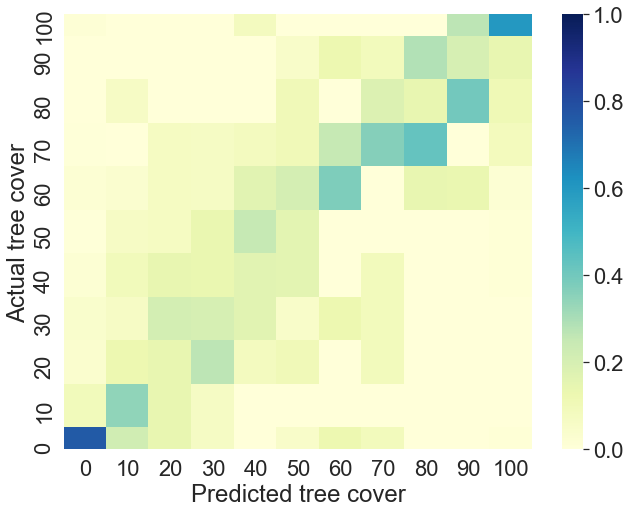

In [143]:
from sklearn import metrics
#pred_round = np.around(preds, 1) * 10
#true_round = np.around(fixed_y, 1) * 10
plt.figure(figsize=(10.5, 8))
sns.set(font_scale=2)
confusion = metrics.confusion_matrix(y_rounded, x_rounded)
confusion = np.flipud(confusion)
ax = sns.heatmap((confusion / (np.sum(confusion, axis = 0))),
           cmap="YlGnBu", vmax = 1.,
                xticklabels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                yticklabels = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0])
ax.set(xlabel='Predicted tree cover', ylabel='Actual tree cover')
plt.show()

In [144]:
from random import shuffle
def species_accum_plot(percents = [x for x in range(10, 100, 1)]):
    ids = [x for x in range(0, len(total_y))]
    shuffle(ids)
    x_shuffle = total_x[ids]
    y_shuffle = (total_y / 49)[ids]
    means = []
    ci = []
    for i in percents:
        x_subset = x_shuffle[:int(len(total_y) * i/100)]
        y_subset = y_shuffle[:int(len(total_y) * i/100)]
        mean_i = np.mean(abs(x_subset - y_subset))
        ci_i = np.percentile(abs(x_subset - y_subset), 90)
        means.append(mean_i)
        ci.append(ci_i)
    return means, ci

overall_means = np.empty((100, 90))
overall_cis = np.empty((100, 90))
for i in range(0, 100):
    means, ci = species_accum_plot()
    overall_means[i, :] = means
    overall_cis[i, :] = ci
    
means = np.mean(overall_means, 0)
ci = np.mean(overall_cis, 0)

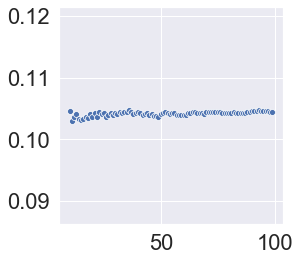

In [145]:
plt.figure(figsize=(4, 4))
sns.scatterplot([x for x in range(10, 100, 1)], means)

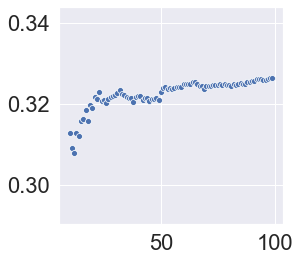

In [146]:
plt.figure(figsize=(4, 4))
sns.scatterplot([x for x in range(10, 100, 1)], ci)

# Compare with original FAO plots

In [147]:
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
countries = np.array(df[df['PLOT_ID'].isin(total_files)]['dryland_assessment_region'])
for i in np.unique(countries):
    country_i_y = total_y[np.argwhere(countries == i)].flatten()
    country_i_x = total_x[np.argwhere(countries == i)].flatten()
    print(i, "\t\t\t",  np.corrcoef(np.array(country_i_y) / 49, country_i_x)[0][1], len(country_i_x))

Australia 			 0.6026207117951062 33
CentralAsia 			 0.6950919969621382 16
EastSouthAmerica 			 0.8560439992372013 29
Europe 			 0.8774237499785424 23
HornAfrica 			 0.890492060682919 46
MiddleEast 			 0.9516864224013589 20
NorthAmerica 			 0.8409722036381625 34
NorthernAfrica 			 0.9869712492782418 15
Sahel 			 0.8908735618037185 43
SouthWestAsia 			 0.8368806195003041 32
SouthernAfrica 			 0.9228625663725755 52
WestSouthAmerica 			 0.8324756450842995 27


In [148]:
fao_y = np.array(df[df['PLOT_ID'].isin(total_files)]['tree_cover'])
aridity = np.array(df[df['PLOT_ID'].isin(total_files)]['Aridity_zone'])
for i in np.unique(aridity):
    country_i_y = total_y[np.argwhere(aridity == i)].flatten()
    country_i_x = total_x[np.argwhere(aridity == i)].flatten()
    print(i, "\t\t\t",  np.corrcoef(np.array(country_i_y) / 49, country_i_x)[0][1], len(country_i_x))

Arid 			 0.828360630778603 45
Dry subhumid 			 0.8873003619544347 116
Hyperarid 			 -0.0584115628105873 27
Semiarid 			 0.8304339790383193 182


In [149]:
print("This is the correlation between the labeled CEO plots and the labeled FAO plots")
np.corrcoef(np.array(total_y) / 49, fao_y)[0][1]

This is the correlation between the labeled CEO plots and the labeled FAO plots


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [150]:
print("This is the correlation between the plot predictions and the labeled FAO plots")
np.corrcoef(np.array(total_x), fao_y)

This is the correlation between the plot predictions and the labeled FAO plots


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [151]:
len(np.argwhere((total_y / 49 - fao_y) < 0.2)) / len(total_y)

ValueError: operands could not be broadcast together with shapes (419,) (370,) 

In [152]:
len(total_y)

419